In [1]:
%load_ext autoreload
%autoreload 2

import pickle as pkl
import gzip
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import sys
sys.path.insert(1, './awp/utils/')

from DataLoader import *
from training import *
from capacity import *

## scikit learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.metrics import accuracy_score, log_loss

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
sns.set()
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
## pytorch
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

In [3]:
def make_tensor(X, y):
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    return torch.Tensor(X), torch.Tensor(y)

In [4]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, n_feature, n_class):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(n_feature, n_class)

    def forward(self, x):       
        outputs = self.linear(x)
        return outputs

In [5]:
def train_model(model, X, y, nepoch, optimizer, criterion, device):
    for _ in range(nepoch):
        model.train()
        optimizer.zero_grad()  # Setting our stored gradients equal to zero
        outputs = model(X.to(device))
        loss = criterion(torch.squeeze(outputs), y.type(torch.LongTensor).to(device))
        loss.backward()  # Computes the gradient of the given tensor w.r.t. graph leaves
        optimizer.step()
    return model

In [6]:
def eval_acc_loss(model, X, y, criterion, device):
    n = X.shape[0]
    outputs = model(X.to(device))
    loss = criterion(torch.squeeze(outputs), y.type(torch.LongTensor).to(device)).item()
    _, predicted = outputs.max(1)
    acc = predicted.eq(y.type(torch.LongTensor).to(device)).sum().item()/n

    return acc, loss

In [7]:
def eval_likelihood(model, X, device):
    outputs = model(X.to(device))
    return F.softmax(outputs, dim=1).cpu().detach().numpy()

In [77]:
def fsgm(n, base_model, X, y, epsilon, criterion, device):
    nclass = 2
    
    likelihood = np.zeros((n, nclass))
    test_acc = np.zeros((n,))
    test_loss = np.zeros((n,))
    
    for i in tqdm(range(n)):
        
        model = LogisticRegression(X.shape[1], nclass)
        model.load_state_dict(copy.deepcopy(base_model.state_dict()))
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        
        
        model.train()
        optimizer.zero_grad()  # Setting our stored gradients equal to zero
        outputs = model(X[i, :].to(device))
        loss = criterion(torch.reshape(outputs, (1, 2)), torch.reshape(y[i], (1,)).type(torch.LongTensor).to(device))
        loss.backward()
        
        with torch.no_grad():
            for w in model.parameters():
                new_w = w + epsilon*w.grad.sign()
                w.copy_(new_w)
    
        test_acc[i], test_loss[i] = eval_acc_loss(model, X, y, criterion, device)
        
        likelihood[i, :] = F.softmax(model(X[i, :].to(device))).cpu().detach().numpy()
    
    return test_acc, test_loss, likelihood

In [78]:
def perturb(n, X_train, y_train, X_test, y_test, epsilon, tol, criterion, device):
    X_traint, y_traint = make_tensor(X_train, y_train)
    X_testt, y_testt = make_tensor(X_test, y_test)
    nfeature, nclass = X_train.shape[1], len(set(y_train))
    
    ## base
    base_model = LogisticRegression(nfeature, nclass)
    optimizer = optim.SGD(base_model.parameters(), lr=0.01, momentum=0.9)
    base_model = train_model(base_model, X_traint, y_traint, 1000, optimizer, criterion, device)
    base_likelihood = eval_likelihood(base_model, X_testt, device)
    
    base_test_acc, base_test_loss = eval_acc_loss(base_model, X_testt, y_testt, criterion, device)
    print('Acc: {:.4f}, Loss: {:.4f}'.format(base_test_acc, base_test_loss))
    ## fsgm
    fsgm_test_acc, fsgm_test_loss, fsgm_likelihood = fsgm(n, base_model, X_testt, y_testt, 
                                                          epsilon, criterion, device)
    
    base_likelihood_n = base_likelihood[:n, :]
    idx = (fsgm_test_loss <= base_test_loss + tol)
    likelihood = np.zeros((2, idx.sum(), nclass))
    likelihood[0, :, :] = base_likelihood_n[idx, :]
    likelihood[1, :, :] = fsgm_likelihood[idx]
    
    cap = compute_capacity(likelihood)
    return cap, fsgm_test_acc, fsgm_test_loss
    

In [79]:
def compute_epsilon_perturb(n, X_train, y_train, X_test, y_test, epsilon, tols, quantile, criterion, device):
    
    cap_mean = np.zeros((len(quantile), len(tols)))
    cap_std = np.zeros((len(quantile), len(tols)))
    
    for i in range(len(tols)):
        cap, _, _ = perturb(n, X_train, y_train, X_test, y_test, epsilon, tols[i], criterion, device)
        
        for j in range(len(quantile)):
            cap_q = np.percentile(cap, quantile[j])
            cap_mean[j, i] = cap[cap>cap_q].mean()
            cap_std[j, i] = cap[cap>cap_q].std()/(cap > cap_q).sum()
    
    return cap_mean, cap_std
    

In [85]:
ntest = 0.3
device = 'cpu'
criterion = nn.CrossEntropyLoss()
n = 1000
epsilon = 1e-5
tols = np.array([0.01, 0.02, 0.05, 0.10])
quantile = np.array([95, 99])

In [86]:
df = load_data(name='compas')
X = df.drop(['is_recid'], axis=1).values
y = df['is_recid'].values
X = np.hstack((X, np.ones((X.shape[0], 1))))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ntest, random_state=42)
compas_cap_mean, compas_cap_std = compute_epsilon_perturb(n, X_train, y_train, X_test, y_test, epsilon, tols, quantile, criterion, device)

Acc: 0.6370, Loss: 0.6333


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1023.78it/s]


Acc: 0.6402, Loss: 0.6339


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1067.45it/s]


Acc: 0.6370, Loss: 0.6333


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1054.80it/s]


Acc: 0.6389, Loss: 0.6331


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1085.28it/s]


In [87]:
df = load_hsls('./data/HSLS/', 'hsls_df_knn_impute_past_v2.pkl', [])
X = df.drop(['gradebin'], axis=1).values
y = df['gradebin'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ntest, random_state=1)
hsls_cap_mean, hsls_cap_std = compute_epsilon_perturb(n, X_train, y_train, X_test, y_test, epsilon, tols, quantile, criterion, device)

Acc: 0.7177, Loss: 0.5419


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 874.05it/s]


Acc: 0.7172, Loss: 0.5417


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 933.95it/s]


Acc: 0.7177, Loss: 0.5421


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 864.37it/s]


Acc: 0.7184, Loss: 0.5423


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1002.23it/s]


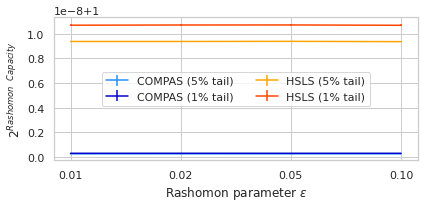

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
compas_color = ['dodgerblue', 'mediumblue']
hsls_color = ['orange', 'orangered']
x = np.arange(len(tols))

for i in range(len(quantile)):
    ax.errorbar(x, y=2**compas_cap_mean[i, :], yerr=compas_cap_std[i, :], 
                label='COMPAS ({:1d}% tail)'.format(100-quantile[i]), color=compas_color[i])

for i in range(len(quantile)):
    ax.errorbar(x, y=2**hsls_cap_mean[i, :], yerr=hsls_cap_std[i, :], 
                label='HSLS ({:1d}% tail)'.format(100-quantile[i]), color=hsls_color[i])
    
ax.set_xticks(np.arange(len(tols)))
ax.set_xticklabels(['{:.2f}'.format(e) for e in tols])
ax.set_xlabel(r'Rashomon parameter $\epsilon$')
ax.set_ylabel(r'$2^{Rashomon\ \ Capacity}$');
ax.legend(loc='center', ncol=2)

plt.tight_layout()
plt.savefig('compas-hsls-fsgm.png', format='png', dpi=300)